In [1]:
import pandas as pd
import numpy as np

In [2]:
import pickle
def save_data(data, outfile):
    with open(outfile, 'wb') as outf:
        pickle.dump(data, outf)

def load_data(infile):
    with open(infile, 'rb') as inf:
        data = pickle.load(inf)
    return data

In [4]:
x_train,y_train=load_data('train_merge_data_statistics.pkl')
x_test1,y_test1,test1_star=load_data('test1_data_statistics.pkl')
x_test2,y_test2,test2_lab=load_data('test2_data_statistics.pkl')
# x_test3,y_test3=load_data('test3_data_statistics.pkl')

In [5]:
x_train = x_train.replace({'ncRNA_splicing':0})
x_test1 = x_test1.replace({'ncRNA_splicing':0})
x_test2 = x_test2.replace({'ncRNA_splicing':0})
# x_test3 = x_test3.replace({'ncRNA_splicing':0})

### AF make bin

In [6]:
af_cut_off=0.005
x_train.loc[x_train['gnomad_genome_controls_AF_popmax']>af_cut_off,'AF']=0
x_train.loc[x_train['gnomad_genome_controls_AF_popmax']<=af_cut_off,'AF']=1
x_test1.loc[x_test1['gnomad_genome_controls_AF_popmax']>af_cut_off,'AF']=0
x_test1.loc[x_test1['gnomad_genome_controls_AF_popmax']<=af_cut_off,'AF']=1
x_test2.loc[x_test2['gnomad_genome_controls_AF_popmax']>af_cut_off,'AF']=0
x_test2.loc[x_test2['gnomad_genome_controls_AF_popmax']<=af_cut_off,'AF']=1
# x_test3.loc[x_test3['gnomad_genome_controls_AF_popmax']>af_cut_off,'AF']=0
# x_test3.loc[x_test3['gnomad_genome_controls_AF_popmax']<=af_cut_off,'AF']=1

In [7]:
x_train = x_train.drop(['gnomad_genome_controls_AF_popmax'], axis=1) 
x_test1 = x_test1.drop(['gnomad_genome_controls_AF_popmax'], axis=1) 
x_test2 = x_test2.drop(['gnomad_genome_controls_AF_popmax'], axis=1) 
# x_test3 = x_test3.drop(['gnomad_genome_controls_AF_popmax'], axis=1) 


In [8]:
x_train = x_train.drop(['Func','ExonicFunc'], axis=1) 
x_test1 = x_test1.drop(['Func','ExonicFunc'], axis=1) 
x_test2 = x_test2.drop(['Func','ExonicFunc'], axis=1) 
# x_test3 = x_test3.drop(['Func','ExonicFunc'], axis=1) 

In [9]:
x_train.columns

Index(['length', 'exonic', 'stream', 'intergenic', 'intronic', 'ncRNA',
       'splicing', 'UTR', 'frameshift_deletion', 'frameshift_insertion',
       'nonframeshift_deletion', 'nonframeshift_insertion', 'startloss',
       'stopgain', 'stoploss', 'exac_syn_z', 'exac_mis_z', 'exac_lof_z',
       'exac_pLI', 'exac_cnv_z', 'RVIS_pop_maf_0_05', 'p_RVIS_pop_maf_0_05',
       'OE-ratio_ExAC_v2', 'p_OE-ratio_ExAC_v2', 'alternative-RVIS_maf_0_0025',
       'alternative-p_RVIS_maf_0_0025', 'Func_b', 'Func_p', 'ExonicFunc_b',
       'ExonicFunc_p', 'AF'],
      dtype='object')

In [8]:
# x_test3_1=x_test3[y_test3==1]
# y_test3_1=y_test3[y_test3==1]

#### baseline

In [10]:
from sklearn.metrics import roc_curve, auc,matthews_corrcoef,average_precision_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    
    optimal_threshold = threshold[np.argmax(tpr - fpr)]

    return optimal_threshold

#cut_off = Find_Optimal_Cutoff(y_train, y_train_pred_prob)
def test_test2_auc(rfc,x_train, y_train,
                   x_test=None,y_test=None,
                   x_test2=None,y_test2=None,
                   ):
    #out=[]
    x_tra, x_val, y_tra, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)
    rfc.fit(x_tra, y_tra)
    y_val_pred=rfc.predict(x_val)
    F1_score = f1_score(y_val, y_val_pred)
#     fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
#     val_auc= auc(fpr, tpr)
    #out.append(format(val_auc,'.3f'))
    
    
    rfc.fit(x_train, y_train)
    cut_off = Find_Optimal_Cutoff(y_train, rfc.predict_proba(x_train)[:,1])
    if (x_test,y_test):
        y_test_pred_prob=rfc.predict_proba(x_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
        test1_auc=auc(fpr, tpr)
        #out.append(format(test1_auc,'.3f'))
        test1_mcc = matthews_corrcoef(y_test,(y_test_pred_prob > cut_off).astype('int'))
        test1_aps =  average_precision_score(y_test,y_test_pred_prob)
        
    if (x_test2,y_test2):
        y_test2_pred_prob=rfc.predict_proba(x_test2)[:,1]
        fpr2, tpr2, _ = roc_curve(y_test2, y_test2_pred_prob)
        test2_auc=auc(fpr2, tpr2)
        test2_mcc = matthews_corrcoef(y_test2,(y_test2_pred_prob > cut_off).astype('int'))
        test2_aps =  average_precision_score(y_test2,y_test2_pred_prob)
        #out.append(format(test2_auc,'.3f'))
#     if (x_test3,y_test3):
#         y_test3_pred_prob=rfc.predict_proba(x_test3)[:,1]
        #out.append(format(np.min(y_test3_pred_prob),'.3f'))
        
#     print('val_f1:',format(F1_score,'.4f'),'\n',
#          'test1: auc=',format(test1_auc,'.3f'),
#           'aps=',format(test1_aps,'.3f'),
#           'mcc=',format(test1_mcc,'.3f'),'\n',
          
#          'test2: auc=',format(test2_auc,'.3f'),  
#           'aps=',format(test2_aps,'.3f'),           
#          ) 
    return [format(F1_score,'.4f'),
           format(test1_auc,'.3f'),
           format(test1_aps,'.3f'),
           format(test1_mcc,'.3f'),
           format(test2_auc,'.3f'),
           format(test2_aps,'.3f')]
    
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifier(random_state=123)
# test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2)

#### autogluon

In [11]:
from autogluon.tabular import TabularDataset, TabularPredictor
# predictor = TabularPredictor(label=x_train, path=save_path).fit(x_train)

In [22]:
from autogluon.tabular import TabularPredictor
x_train['label']=y_train
x_train=x_train.reset_index()
predictor = TabularPredictor(label='label').fit(x_train)

No path specified. Models will be saved in: "AutogluonModels/ag-20220401_051356/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220401_051356/"
AutoGluon Version:  0.4.0
Python Version:     3.8.13
Operating System:   Linux
Train Data Rows:    96320
Train Data Columns: 32
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0.0, 1.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    42223.87 MB
	Train Data (Original)  Memory Usage: 24.66 MB (0.1% of available memory)
	Inferring data type of each

In [27]:
x_test1=x_test1.reset_index()
y_test1=y_test1.reset_index()
y_pred = predictor.predict(x_test1)
#print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test1['tag'], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.980105791942513
Evaluations on test data:
{
    "accuracy": 0.980105791942513,
    "balanced_accuracy": 0.9707112034770389,
    "mcc": 0.9488067494935284,
    "f1": 0.962171052631579,
    "precision": 0.9740010245901639,
    "recall": 0.950625
}


In [32]:
y_pred_proba=predictor.predict_proba(x_test1)[1]
fpr, tpr, _ = roc_curve(y_test1['tag'], y_pred_proba)
auc(fpr, tpr)

0.9913055697221088

In [31]:
y_pred_proba

,0,1
0,0.629128,0.370872
1,0.629875,0.370125
2,0.629773,0.370226
3,0.629128,0.370872
4,0.630765,0.369235
...,...,...
30054,0.407120,0.592880
30055,0.407120,0.592880
30056,0.407120,0.592880
30057,0.407120,0.592880


#### xgboost 

In [ ]:
import xgboost as xgb # direct xgboost library
from xgboost.sklearn import XGBClassifier # sklearn wrapper   
from sklearn.model_selection import GridSearchCV 

In [ ]:
def get_class_weight(y_train):
    
    from sklearn.utils.class_weight import compute_class_weight
    cls = np.unique(y_train)
    cls_weight = compute_class_weight('balanced', cls, y_train)
    class_weight_dict = dict(zip(cls, cls_weight))
    return class_weight_dict

In [57]:

init_est = XGBClassifier(learning_rate =0.3, # this is analogue to eta, Typical: 0.01-0.2
                         n_estimators=260, # the number of iterations/trees.  
                         max_depth=5, # Typical values: 3-10 
                         min_child_weight=1,
                         gamma=0, # min_split_loss
                         subsample=0.8, # the fraction of observations to be randomly samples for each tree. 0.5-1
                         colsample_bytree=0.8, # the fraction of columns to be randomly samples for each tree. 0.5-1
#                          objective= 'multi:softprob', 
                         reg_alpha = 0.01,
                         seed=123, early_stopping_rounds=50,n_jobs=4)


'''
Tune hyperparameters 
'''
def xgb_train_cv(x_train, y_train, init_estimator = init_est, n_folds = 5, scoring = 'f1'):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    param_groups = {
        '1':{ # 1. Tune max_depth and min_child_weight
            'max_depth': range(8,16),
            'min_child_weight':range(1,4)
        },
        '2':{ # 2. Tune gamma
            'gamma':[i/10.0 for i in range(0,5)]
        },
        '3':{ # 3. Tune subsample and colsample_bytree
            'subsample':[i/10.0 for i in range(6,10)],
            'colsample_bytree':[i/10.0 for i in range(6,10)]
        },
        '4':{ # 4. Tuning Regularization Parameters
            'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
        },
        '5': { # 5. Tuning learning rate and the number of estimators
            'learning_rate':[ .2, .1, .05, .01, .005, .001],
            'n_estimators': [int(x) for x in range(50,200,5)],
        }
    }
    best_param = {}
    cv_results = {}
    best_est = init_est
    
    for k, params in param_groups.items():
        xgb_cv = GridSearchCV(estimator = best_est, param_grid = params, 
                              scoring=scoring,n_jobs=4,cv=n_folds,return_train_score=True)
        xgb_cv.fit(x_train,y_train)
        best_param[k] = xgb_cv.best_params_
        cv_results[k] = xgb_cv.cv_results_
        
        best_est = xgb_cv.best_estimator_
        best_est.get_booster().set_param(xgb_cv.best_params_)
    
    return cv_results,best_param,best_est


In [58]:
# train model based on f1_weighted metric
# imbalance data must use f1_weighted
xgb_cv_results, best_param,best_est= xgb_train_cv(x_train, y_train.values, init_estimator=init_est,scoring='f1_weighted')



[10:40:55] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:40:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:43:31] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:43:31] WARNING: ../src/learner.cc:1095: Starting in XGBoos

In [60]:
best_est

[13:00:02] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=50, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=85, n_jobs=4, num_parallel_tree=1, random_state=123,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [59]:
best_param

{'1': {'max_depth': 10, 'min_child_weight': 1},
 '2': {'gamma': 0.4},
 '3': {'colsample_bytree': 0.9, 'subsample': 0.9},
 '4': {'reg_alpha': 0.005},
 '5': {'learning_rate': 0.01, 'n_estimators': 85}}

In [61]:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=50, gamma=0.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1,
              n_estimators=85, n_jobs=4, num_parallel_tree=1, random_state=123,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=123,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)
test_test2_auc(xgb,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)

[13:00:21] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:00:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:00:24] WARNING: ../src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:00:24] WARNING: ../src/learner.cc:1095: Starting in XGBoos

In [ ]:

init_est = GradientBoostingClassifier(learning_rate=0.15, 
                                      #min_impurity_decrease=0,
                           min_samples_leaf=0.01, 
                                      #min_weight_fraction_leaf=0,
                           random_state=123)


'''
Tune hyperparameters 
'''
def gdbt_train_cv(x_train, y_train, init_estimator = init_est, n_folds = 5, scoring = 'f1_weighted'):
    
    import warnings
    warnings.filterwarnings("ignore")
    
    param_groups = {
        '1':{ # 1. Tune max_depth and min_child_weight
            'learning_rate':[0.1,0.15,0.2]
        },
#         '2':{ # 2. Tune 
#             'min_impurity_decrease':[0,0.01,]
#         },
        '2':{ # 3. 
#             'min_samples_split':range(800,1900,200), 
            'min_samples_leaf':[0.01,0.1,0.2]

        },
#         '4':{ # 4. 
#             'min_weight_fraction_leaf':['None',2,3,4,5,6,7,8]
#         },
#         '3': { # 5. Tuning learning rate and the number of estimators
#             'tol':[1e-5,1e-3,1e-4]
#         }
    }
    best_param = {}
    cv_results = {}
    best_est = init_est
    
    for k, params in param_groups.items():
        gdbt_cv = GridSearchCV(estimator = best_est, param_grid = params, 
                              scoring=scoring,n_jobs=10,cv=n_folds,return_train_score=True)
        gdbt_cv.fit(x_train,y_train)
        best_param[k] = gdbt_cv.best_params_
        cv_results[k] = gdbt_cv.cv_results_
        
        best_est = gdbt_cv.best_estimator_
#         best_est.get_booster().set_param(gdbt_cv.best_params_)
    
    return cv_results,best_param,best_est


In [ ]:
gdbt_cv_results, best_param,best_est= gdbt_train_cv(x_train, y_train.values, init_estimator=init_est,scoring='f1_weighted')



In [ ]:
best_est

In [188]:
test_test2_auc(best_est,x_train, y_train,x_test1,y_test1,x_test2,y_test2)

['0.9856', '0.997', '0.991', '0.946', '0.967', '0.932']

In [181]:
clf=GradientBoostingClassifier(learning_rate=0.15, min_impurity_decrease=0,
                           min_samples_leaf=0.01, min_weight_fraction_leaf=0,
                           random_state=123, subsample=1)
test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2)

['0.9885', '0.997', '0.992', '0.951', '0.969', '0.939']

In [137]:
para_list = [
            'loss',#loss loss{‘deviance’, ‘exponential’}, default=’deviance’
             'learning_rate',#learning_ratefloat, default=0.1
             'n_estimators',#n_estimatorsint, default=100
             'subsample',#subsamplefloat, default=1.0
             'criterion',#criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}, default=’friedman_mse’
             'min_samples_split',#min_samples_splitint or float, default=2
             'max_depth',#max_depthint, default=3
             'min_samples_leaf',#min_samples_leafint or float, default=1
             'min_weight_fraction_leaf',#min_weight_fraction_leaffloat, default=0.0
             'min_impurity_decrease',#min_impurity_decreasefloat, default=0.0
             'max_features',#max_features{‘auto’, ‘sqrt’, ‘log2’}, int or float, default=None
             'max_leaf_nodes',#max_leaf_nodesint, default=None
             #'tolfloat',#tolfloat, default=1e-4
            ]
para_space=[
            ['exponential'],#loss loss{‘deviance’, ‘exponential’}, default=’deviance’
             [0.001,0.01,0.05,0.2,0.4],#learning_ratefloat, default=0.1
             [2,4,8,10,20,40,60,100,140,160,200,300],#n_estimatorsint, default=100
             [0.6,0.8,0.9],#subsamplefloat, default=1.0
             ['squared_error'],#criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}, default=’friedman_mse’
             [3,4,6,8,10],#min_samples_splitint or float, default=2
             [2,4,6,8,10,20,40],#max_depthint, default=3
             [2,4,6,10,20,40,100,200],#min_samples_leafint or float, default=1
             [0.001,0.01,0.1],#min_weight_fraction_leaffloat, default=0.0
             [0.001,0.01,0.1],#min_impurity_decreasefloat, default=0.0
             ['auto','sqrt','log2',2,4,6,10,20],#max_features{‘auto’, ‘sqrt’, ‘log2’}, int or float, default=None
             [2,4,6,10,20],#max_leaf_nodesint, default=None
             #[1e-6,1e-5,1e-3,1e-2]#tolfloat, default=1e-4    
]

In [130]:
#para=pd.DataFrame()
val_list=[]
test1_auc_list=[]
test1_aps_list=[]
test1_mcc_list=[]
test2_auc_list=[]
test2_aps_list=[]

for m in range(13):
    for n in para_space[m]:
        para_dict={para_list[m]:n}
        clf = GradientBoostingClassifier(random_state=123,**para_dict)
        
        out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2)
        val_list.append(out[0])
        test1_auc_list.append(out[1])
        test1_aps_list.append(out[2])
        test1_mcc_list.append(out[3])
        test2_auc_list.append(out[4])
        test2_aps_list.append(out[5])

TypeError: __init__() got an unexpected keyword argument 'tolfloat'

In [149]:

para_df=pd.DataFrame()
para_index=[]
para_value=[]
for m in range(12):
    for n in para_space[m]:
        para_index.append(para_list[m])
        para_value.append(n)

para_df['index']=para_index
para_df['value']=para_value
para_df['val_f1']=val_list
para_df['test1_auc']=test1_auc_list
para_df['test1_aps']=test1_aps_list
para_df['test1_mcc']=test1_mcc_list
para_df['test2_auc']=test2_auc_list
para_df['test2_aps']=test2_aps_list
para_df[(para_df['test1_auc'].astype(float)>=0.990) & 
        (para_df['test1_aps'].astype(float)>=0.981) &
        (para_df['test1_mcc'].astype(float)>=0.924) & 
        (para_df['test2_auc'].astype(float)>=0.958)].sort_values(by=['test2_aps'])

,index,value,val_f1,test1_auc,test1_aps,test1_mcc,test2_auc,test2_aps
40,min_samples_leaf,100,0.9886,0.995,0.987,0.953,0.962,0.921
42,min_weight_fraction_leaf,0.001,0.9879,0.994,0.987,0.951,0.962,0.921
56,max_leaf_nodes,2,0.9751,0.997,0.991,0.953,0.961,0.922
49,max_features,sqrt,0.9861,0.997,0.992,0.947,0.964,0.922
57,max_leaf_nodes,4,0.9869,0.997,0.991,0.950,0.962,0.923
59,max_leaf_nodes,10,0.9887,0.995,0.988,0.952,0.962,0.924
45,min_impurity_decrease,0.001,0.9887,0.995,0.988,0.952,0.962,0.924
46,min_impurity_decrease,0.01,0.9887,0.995,0.988,0.952,0.962,0.924
47,min_impurity_decrease,0.1,0.9885,0.995,0.988,0.952,0.962,0.924
48,max_features,auto,0.9887,0.995,0.988,0.952,0.962,0.924


In [145]:
para_df['test1_auc'].astype(float)>=0.990

0      True
1     False
2     False
3      True
4      True
      ...  
56     True
57     True
58     True
59     True
60     True
Name: test1_auc, Length: 61, dtype: bool

'0.9867'

In [22]:
#test1: auc=0.990, aps=0.981, mcc=0.924
#test2: auc=0.958, aps=0.953

In [35]:
# from xgboost import XGBClassifier
# clf = XGBClassifier(random_state=123,n_jobs=20) 
# test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)


In [34]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(random_state=123,n_jobs=20)
test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)

val_f1: 0.9886 
 test1: auc= 0.993 aps= 0.985 mcc= 0.942 
 test2: auc= 0.914 aps= 0.855


#### Parameter Tuning

In [36]:
#loss loss{‘deviance’, ‘exponential’}, default=’deviance’
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=123,loss='exponential')
test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)

val_f1: 0.9867 
 test1: auc= 0.993 aps= 0.986 mcc= 0.945 
 test2: auc= 0.964 aps= 0.928


In [37]:
loss='deviance'
#learning_ratefloat, default=0.1
from sklearn.ensemble import GradientBoostingClassifier
for para in [0.001,0.01,0.05,0.15,0.2,0.3]:
    
    clf = GradientBoostingClassifier(random_state=123,loss=loss,
                                    learning_rate=para)
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
#     print(para,out)

#

val_f1: 0.9799 
 test1: auc= 0.976 aps= 0.937 mcc= 0.932 
 test2: auc= 0.812 aps= 0.746
0.001 None
val_f1: 0.9769 
 test1: auc= 0.989 aps= 0.979 mcc= 0.930 
 test2: auc= 0.951 aps= 0.913
0.01 None
val_f1: 0.9832 
 test1: auc= 0.992 aps= 0.983 mcc= 0.946 
 test2: auc= 0.893 aps= 0.840
0.05 None
val_f1: 0.9903 
 test1: auc= 0.996 aps= 0.989 mcc= 0.950 
 test2: auc= 0.965 aps= 0.930
0.15 None
val_f1: 0.9905 
 test1: auc= 0.995 aps= 0.988 mcc= 0.951 
 test2: auc= 0.950 aps= 0.909
0.2 None
val_f1: 0.9908 
 test1: auc= 0.995 aps= 0.988 mcc= 0.951 
 test2: auc= 0.967 aps= 0.930
0.3 None


In [38]:
learning_rate=0.3
#n_estimatorsint, default=100
from sklearn.ensemble import GradientBoostingClassifier
for para in [10,20,40,60,80,100,120,140,160,180,200,300]:
    
    clf = GradientBoostingClassifier(random_state=123,loss=loss,learning_rate=learning_rate,
                                    n_estimators=para)
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)
    
#

val_f1: 0.9811 
 test1: auc= 0.993 aps= 0.983 mcc= 0.941 
 test2: auc= 0.952 aps= 0.914
10 None
val_f1: 0.9862 
 test1: auc= 0.991 aps= 0.982 mcc= 0.947 
 test2: auc= 0.954 aps= 0.916
20 None
val_f1: 0.9893 
 test1: auc= 0.994 aps= 0.987 mcc= 0.952 
 test2: auc= 0.968 aps= 0.933
40 None
val_f1: 0.9903 
 test1: auc= 0.995 aps= 0.988 mcc= 0.951 
 test2: auc= 0.966 aps= 0.928
60 None
val_f1: 0.9906 
 test1: auc= 0.995 aps= 0.988 mcc= 0.953 
 test2: auc= 0.966 aps= 0.929
80 None
val_f1: 0.9908 
 test1: auc= 0.995 aps= 0.988 mcc= 0.951 
 test2: auc= 0.967 aps= 0.930
100 None
val_f1: 0.9908 
 test1: auc= 0.995 aps= 0.988 mcc= 0.951 
 test2: auc= 0.967 aps= 0.932
120 None
val_f1: 0.9908 
 test1: auc= 0.996 aps= 0.989 mcc= 0.951 
 test2: auc= 0.965 aps= 0.929
140 None
val_f1: 0.9908 
 test1: auc= 0.996 aps= 0.989 mcc= 0.949 
 test2: auc= 0.965 aps= 0.930
160 None
val_f1: 0.9908 
 test1: auc= 0.996 aps= 0.989 mcc= 0.950 
 test2: auc= 0.964 aps= 0.930
180 None
val_f1: 0.9907 
 test1: auc= 0.995 

In [44]:
n_estimators=100
#subsamplefloat, default=1.0
from sklearn.ensemble import GradientBoostingClassifier
for para in [0.2,0.5,0.6,0.7,0.8,0.9]:
    clf = GradientBoostingClassifier(random_state=123,
                                     loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,
                                    subsample=para)
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)

#

0.2 [0.9982050369578003, 0.9944515050546263, 0.9605509380657685, 0.008004939446802363]
0.5 [0.9988045526305819, 0.9955821943424453, 0.9595631187339754, 0.005664098634750396]
0.6 [0.9987415501025584, 0.995086532141076, 0.955152004094437, 0.004705597032039711]
0.7 [0.9987350881666216, 0.9952242112063103, 0.9657205405821843, 0.006771766847312281]
0.8 [0.9987996428527353, 0.9950841861598441, 0.963879415048888, 0.0058126154158870515]
0.9 [0.9987828008595724, 0.9952845692234462, 0.9666495517070646, 0.004989525508528628]


In [45]:
subsample=1
#criterion{‘friedman_mse’, ‘squared_error’, ‘mse’, ‘mae’}, default=’friedman_mse’
from sklearn.ensemble import GradientBoostingClassifier
for para in ['squared_error']:
    clf = GradientBoostingClassifier(random_state=123,
                                     loss=loss,learning_rate=learning_rate,
                                     n_estimators=n_estimators,subsample=subsample,
                                    criterion=para)
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)

#

squared_error [0.998751197196242, 0.9957442058796863, 0.9640506429384115, 0.007062776925011272]


In [46]:
criterion='friedman_mse'
#
#min_samples_splitint or float, default=2
from sklearn.ensemble import GradientBoostingClassifier
for para in [2,4,6,8,10,20]:
    clf = GradientBoostingClassifier(random_state=123,
            loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
            criterion=criterion,
            min_samples_split=para)
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)

#

2 [0.9987515636780132, 0.9957442058796863, 0.9640506429384115, 0.007062776925011272]
4 [0.9987500222987991, 0.9958357728138176, 0.9636065866601026, 0.00628503116506283]
6 [0.9987499145100428, 0.9958349001541321, 0.9636065866601026, 0.006285211433473836]
8 [0.9987389308357817, 0.9958358181467881, 0.963607761062637, 0.006285153499357481]
10 [0.9987388984991548, 0.9957340087945963, 0.9628942821628924, 0.006422869790063074]
20 [0.998823340210795, 0.9956971899224806, 0.964337901798339, 0.006917161891105978]


In [52]:
min_samples_split=2
#max_depthint, default=3
from sklearn.ensemble import GradientBoostingClassifier
for para in [2,4,5,6,8,10,20,40]:
    clf = GradientBoostingClassifier(random_state=123,
            loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
            criterion=criterion,min_samples_split=min_samples_split,
            max_depth=para)
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)

#

2 [0.9985661885750278, 0.9969394974840202, 0.9670875891723844, 0.030946204533307202]
4 [0.998913694135715, 0.9940547678951901, 0.9583757977716416, 0.0011604516478959832]
5 [0.9990726017096051, 0.993134797588286, 0.9562662478590641, 0.0008635898285498301]
6 [0.9990654930411309, 0.9923399859467791, 0.9511540883066149, 0.0010940589345242186]
8 [0.9987721405515798, 0.9942711818305454, 0.9510617949474384, 0.0003431345644242474]
10 [0.9988154123477733, 0.9951417533659731, 0.956372604688591, 0.00015099408369374543]
20 [0.9929209626549147, 0.9776628898635474, 0.7835682559229818, 1.4482012479986888e-07]
40 [0.989850071768449, 0.97924061040845, 0.8218840340914964, 1.4482135679399309e-07]


In [53]:
max_depth=3
#min_samples_leafint or float, default=1
from sklearn.ensemble import GradientBoostingClassifier
for para in [0.0001,0.001,0.01,0.1,0.2,0.3,0.4 ,0.5]:
    clf = GradientBoostingClassifier(random_state=123,
            loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
            criterion=criterion,min_samples_split=min_samples_split,max_depth=max_depth,
            min_samples_leaf=para)
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)


0.0001 [0.998802197446258, 0.9954273085815313, 0.9660582693910301, 0.006072266921068976]
0.001 [0.998745602959793, 0.9950043689650482, 0.9630078322079425, 0.005313337358637254]
0.01 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
0.1 [0.9967101955390438, 0.9928267005530622, 0.9449240296616499, 0.023559508319652235]
0.2 [0.9958173920499649, 0.9918588359626456, 0.9483213266332884, 0.01855200891405033]
0.3 [0.9931111451364285, 0.9865359292125663, 0.9405894126671996, 0.08285966208311321]
0.4 [0.9919456630412457, 0.9864139466884265, 0.9408323671915151, 0.1024771912799908]
0.5 [0.5023733521187578, 0.5096193135454916, 0.5181341844150207, 0.40763389826404295]


In [54]:
min_samples_leaf=0.01
#
#min_weight_fraction_leaffloat, default=0.0
from sklearn.ensemble import GradientBoostingClassifier
for para in [0.001,0.01,0.1,0.2,0.5]:
    clf = GradientBoostingClassifier(random_state=123,
            loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
            criterion=criterion,min_samples_split=min_samples_split,max_depth=max_depth,                     
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=para)
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)

#

0.001 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
0.01 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
0.1 [0.9967101955390438, 0.9928267005530622, 0.9449240296616499, 0.023559508319652235]
0.2 [0.9958173920499649, 0.9918588359626456, 0.9483213266332884, 0.01855200891405033]
0.5 [0.5023733521187578, 0.5096193135454916, 0.5181341844150207, 0.40763389826404295]


In [55]:
min_weight_fraction_leaf=0
#min_impurity_decreasefloat, default=0.0
from sklearn.ensemble import GradientBoostingClassifier
for para in [0.001,0.01,0.1,0.2]:
    clf = GradientBoostingClassifier(random_state=123,
            loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
            criterion=criterion,min_samples_split=min_samples_split,max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,min_weight_fraction_leaf=min_weight_fraction_leaf,
            min_impurity_decrease=para                        )
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)

#

0.001 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
0.01 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
0.1 [0.9981043838172213, 0.997389186386509, 0.9646727092808804, 0.02529538114355442]
0.2 [0.9979548808123134, 0.9973355433156534, 0.9683433044023184, 0.023587959009983717]


In [56]:
min_impurity_decrease=0
#max_features{‘auto’, ‘sqrt’, ‘log2’}, int or float, default=None
from sklearn.ensemble import GradientBoostingClassifier
for para in ['auto','sqrt','log2',2,4,6,8,10,20]:
    clf = GradientBoostingClassifier(random_state=123,
            loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
            criterion=criterion,min_samples_split=min_samples_split,max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,min_weight_fraction_leaf=min_weight_fraction_leaf,
            min_impurity_decrease=min_impurity_decrease,
            max_features=para                        )
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)

#

auto [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
sqrt [0.9980924462124675, 0.9976671511627907, 0.9668777674795723, 0.02283456734477559]
log2 [0.9978350251048097, 0.9977889778548439, 0.9668615754046287, 0.037967201142831]
2 [0.9973220368561017, 0.9973091425268599, 0.9684143410756211, 0.02555153176333283]
4 [0.9978350251048097, 0.9977889778548439, 0.9668615754046287, 0.037967201142831]
6 [0.9981148285477013, 0.9975242814724149, 0.9707603422584795, 0.013117920394647967]
8 [0.9980134154963907, 0.9975707619339046, 0.9678391774343721, 0.02195555822749888]
10 [0.9979980933246908, 0.9975397966816266, 0.9644688330008991, 0.019999716805468682]
20 [0.9979378178522001, 0.9974567976789519, 0.9687106868751592, 0.020252587540921914]


In [57]:
max_features=None
#
#max_leaf_nodesint, default=None
from sklearn.ensemble import GradientBoostingClassifier
for para in [2,4,6,8,10,20]:
    clf = GradientBoostingClassifier(random_state=123,
            loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
            criterion=criterion,min_samples_split=min_samples_split,max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,min_weight_fraction_leaf=min_weight_fraction_leaf,
            min_impurity_decrease=min_impurity_decrease,
            max_features=max_features,                        
            max_leaf_nodes=para                        )
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)

#

2 [0.996427330895475, 0.9972921709959655, 0.9602794895999609, 0.15728621144128085]
4 [0.9975658280755327, 0.9973558581531349, 0.9661118515066646, 0.011324534310849536]
6 [0.9981038556523157, 0.9972754657962736, 0.9675309848492679, 0.02106270085198436]
8 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
10 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
20 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]


In [58]:
#
max_leaf_nodes=None
#tolfloat, default=1e-4
from sklearn.ensemble import GradientBoostingClassifier
for para in [1e-6,1e-5,1e-3,1e-2,1e-1]:
    clf = GradientBoostingClassifier(random_state=123,
            loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
            criterion=criterion,min_samples_split=min_samples_split,max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,min_weight_fraction_leaf=min_weight_fraction_leaf,
            min_impurity_decrease=min_impurity_decrease,
            max_features=max_features,                        
            max_leaf_nodes=max_leaf_nodes,
            tol=para                        )
    out=test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)
    print(para,out)

#

1e-06 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
1e-05 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
0.001 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
0.01 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]
0.1 [0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]


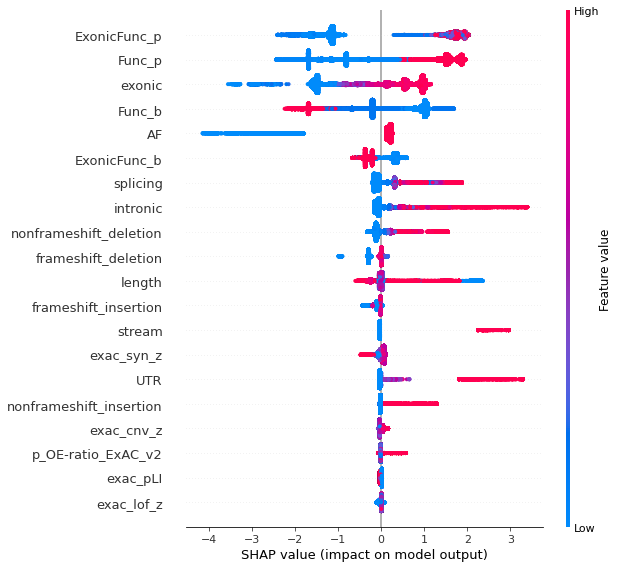

In [59]:
clf=GradientBoostingClassifier(random_state=123,
            loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
            criterion=criterion,min_samples_split=min_samples_split,max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,min_weight_fraction_leaf=min_weight_fraction_leaf,
            min_impurity_decrease=min_impurity_decrease,
            max_features=max_features,                        
            max_leaf_nodes=max_leaf_nodes,                        
            )
import shap
clf.fit(x_train,y_train)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_train)
#shap.summary_plot(shap_values, x_train)
shap.summary_plot(shap_values, x_train)

In [60]:
shap_df=pd.DataFrame()
shap_df['feature']=x_train.columns.to_list()
shap_df['importance']=np.mean(np.abs(shap_values),axis=0)
shap_df=shap_df.sort_values(by=['importance'],ascending=False)

In [61]:
shap_df

,feature,importance
29,ExonicFunc_p,1.494063
27,Func_p,1.399403
1,exonic,0.978229
26,Func_b,0.972366
30,AF,0.363352
28,ExonicFunc_b,0.297335
6,splicing,0.199858
4,intronic,0.183388
10,nonframeshift_deletion,0.161173
8,frameshift_deletion,0.126682


In [65]:
x_train_num

,ExonicFunc_p
0,-0.713075
1,0.783842
2,0.783842
3,0.783842
4,5.208232
...,...
38038,-1.336501
38039,-1.336501
38040,-1.336501
38041,-1.336501


In [66]:
##
for num in range(29):
    num_sel=shap_df.iloc[:num+1,0].to_list()
    x_train_num=x_train[num_sel]
    x_test1_num=x_test1[num_sel]
    x_test2_num=x_test2[num_sel]
    x_test3_num=x_test3_1[num_sel]
    out=test_test2_auc(clf,x_train_num, y_train,x_test1_num,y_test1,x_test2_num,y_test2,x_test3_num,y_test3_1)
    print(num+1,out)

1 [0.9752016336895051, 0.9752630587288635, 0.9404777563462364, 0.4284114444558269]
2 [0.9881036460031848, 0.9915352945509769, 0.9497187335290044, 0.42878343099159666]
3 [0.9957311233189061, 0.9871345907566073, 0.9019283014334287, 0.007139431168853504]
4 [0.996120294623319, 0.9829442517793191, 0.8959326388543092, 0.003681275127350129]
5 [0.9967926431586934, 0.9964233079468697, 0.9398352407196362, 0.007955270451481077]
6 [0.996479225792168, 0.9969537518699849, 0.9405191099954808, 0.015278623584028815]
7 [0.9965276822275365, 0.9968608306133551, 0.9577221253209642, 0.017731437342319637]
8 [0.9976268634587547, 0.9966040476676186, 0.9535796699412142, 0.020197202252664498]
9 [0.9977169910272866, 0.9965613921755291, 0.9557337590699106, 0.017900491722510754]
10 [0.9977567704677779, 0.9964288074028742, 0.9397471458495206, 0.015699493718634973]
11 [0.9981345161640288, 0.997347471553561, 0.9595512279083138, 0.029665950076425862]
12 [0.9981145752441241, 0.9972889495217372, 0.9541282186850262, 0.030

In [67]:
test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2,x_test3_1,y_test3_1)

[0.9981685935793149, 0.9974523720476903, 0.967964544904925, 0.0220333903978171]

In [68]:
#x_test1[test1_star>=2]
test_test2_auc(clf,x_train, y_train,
               x_test1[test1_star>=2],y_test1[test1_star>=2],
               x_test2[test2_lab.astype('int')>=2],y_test2[test2_lab.astype('int')>=2],x_test3_1,y_test3_1)

[0.9981685935793149, 0.997359470103831, 0.9831622193362901, 0.0220333903978171]

In [70]:
#x_test1[test1_star>=2]
test_test2_auc(clf,x_train, y_train,
               x_test1[test1_star>=2],y_test1[test1_star>=2],
               x_test2[test2_lab.astype('int')>=3],y_test2[test2_lab.astype('int')>=3],x_test3_1,y_test3_1)

[0.9981685935793149, 0.997359470103831, 0.9889023605681199, 0.0220333903978171]

In [71]:
clf

GradientBoostingClassifier(learning_rate=0.15, min_impurity_decrease=0,
                           min_samples_leaf=0.01, min_weight_fraction_leaf=0,
                           random_state=123, subsample=1)

In [72]:
# clf=GradientBoostingClassifier(random_state=123,
#             loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
#             criterion=criterion,min_samples_split=min_samples_split,max_depth=max_depth,
#             min_samples_leaf=min_samples_leaf,min_weight_fraction_leaf=min_weight_fraction_leaf,
#             min_impurity_decrease=min_impurity_decrease,
#             max_features=max_features,                        
#             max_leaf_nodes=max_leaf_nodes,                        
#             )
# clf.fit(x_train,y_train)
x_test3_prob = clf.predict_proba(x_test3)[:,1]

In [101]:
x_test1_prob = clf.predict_proba(x_test1)[:,1]
x_test2_prob = clf.predict_proba(x_test2)[:,1]
save_data([x_test1_prob,x_test2_prob],'x_test1_test2_prob.pkl')

In [73]:
pd.DataFrame(x_test3_prob).to_csv('x_test3_prob_AFbins2_statistics.gz',index=False,compression='gzip')

In [85]:
y_train_pred_prob=clf.predict_proba(x_train)[:,1]
from sklearn.metrics import roc_curve, auc
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    
    optimal_threshold = threshold[np.argmax(tpr - fpr)]

    return optimal_threshold

cut_off = Find_Optimal_Cutoff(y_train, y_train_pred_prob)
print('cut_off = ',cut_off)

cut_off =  0.5739323582253674


In [ ]:
# clf=GradientBoostingClassifier(random_state=123,
# #             loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,subsample=subsample,
# #             criterion=criterion,min_samples_split=min_samples_split,max_depth=max_depth,
# #             min_samples_leaf=min_samples_leaf,min_weight_fraction_leaf=min_weight_fraction_leaf,
# #             min_impurity_decrease=min_impurity_decrease,
# #             max_features=max_features,                        
# #             max_leaf_nodes=max_leaf_nodes,                        
#             )
# clf.fit(x_train,y_train)
# test_test2_auc(clf,x_train, y_train,x_test1,y_test1,x_test2,y_test2)

(0.1, 0.6)

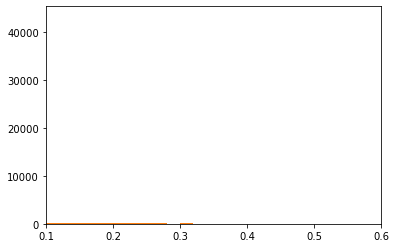

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
hist = plt.hist(clf.predict_proba(x_train[y_train==1])[:,1], bins=50,label='p')
hist = plt.hist(clf.predict_proba(x_train[y_train==0])[:,1], bins=50,label='b')
plt.xlim(0.1,0.6)

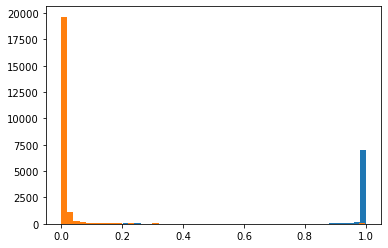

In [77]:
hist = plt.hist(clf.predict_proba(x_test1[y_test1==1])[:,1], bins=50,label='p')
hist = plt.hist(clf.predict_proba(x_test1[y_test1==0])[:,1], bins=50,label='b')


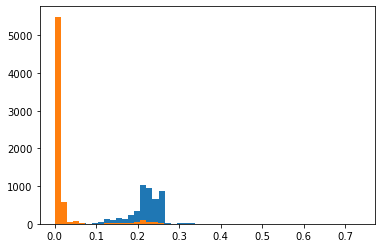

In [78]:
hist = plt.hist(clf.predict_proba(x_test2[y_test2==1])[:,1], bins=50,label='p')
hist = plt.hist(clf.predict_proba(x_test2[y_test2==0])[:,1], bins=50,label='b')
# plt.xlim(-0.05,1)

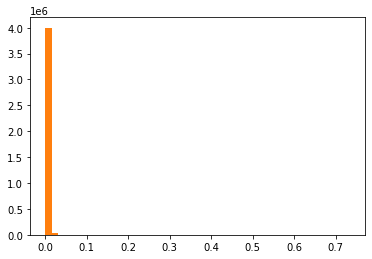

In [79]:
hist = plt.hist(clf.predict_proba(x_test3[y_test3==1])[:,1], bins=50,label='p',)
hist = plt.hist(clf.predict_proba(x_test3[y_test3==0])[:,1], bins=50,label='b')
# plt.xlim(-0.05,1)

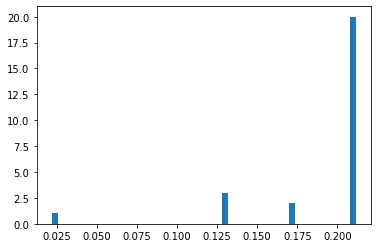

In [80]:
hist = plt.hist(clf.predict_proba(x_test3[y_test3==1])[:,1], bins=50,label='p',)


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
def norm_continue_feats(X_trn_df, X_tst_df, method='standard'):
    cols_lst = list(X_trn_df.columns)
    
    if method=='standard':
        scaler = StandardScaler()
    if method=='minmax':
        scaler = MinMaxScaler(feature_range=(-1, 1))
    
    scaler.fit(X_trn_df.values)
    
    trn_norm = scaler.transform(X_trn_df.values)
    tst_norm = scaler.transform(X_tst_df.values)
    
    return pd.DataFrame(data=trn_norm, columns=cols_lst),pd.DataFrame(data=tst_norm, columns=cols_lst)
    


In [ ]:
x_train_norm,x_test1_norm = norm_continue_feats(x_train, x_test1, method='standard')
x_train_norm,x_test2_norm = norm_continue_feats(x_train, x_test2, method='standard')
test_test2_auc(cal_model,x_train_norm, y_train,x_test1_norm,y_test1,x_test2_norm,y_test2)

In [ ]:
def calc_bins(labels_oneh, preds):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins) 
    binned = np.digitize(preds, bins)  
    
    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(preds[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (labels_oneh[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (preds[binned==bin]).sum() / bin_sizes[bin]
    return bins, binned, bin_accs, bin_confs, bin_sizes
def ece(labels_oneh, preds):
    ECE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(labels_oneh,preds)
    
    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        
    return ECE

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
cal_model = CalibratedClassifierCV(clf,cv=5, method='sigmoid')

   
y_train_pred_prob = clf.predict_proba(x_train)[:,1]
y_train_pred = clf.predict(x_train)

cal_model.fit(x_train, y_train)
cal_prob =  cal_model.predict_proba(x_train)[:,1]

    
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

uncal_fop,uncal_mpv = calibration_curve(y_train, y_train_pred_prob, n_bins=10)
cal_fop,cal_mpv = calibration_curve(y_train, cal_prob, n_bins=10)
#cal_score_loss
from sklearn.metrics import brier_score_loss
uncal_score_loss = brier_score_loss(y_train, y_train_pred_prob)
cal_score_loss = brier_score_loss(y_train, cal_prob)
#cal_ece
uncal_ece = ece(y_train, y_train_pred_prob)
cal_ece = ece(y_train, cal_prob)


fig, axs = plt.subplots(1, 2, figsize = (11.7,5.27))

# plot perfectly calibrated
axs[0].plot([0, 1], [0, 1], 'k--',label="Perfectly Calibrated")
# plot model uncalibration
axs[0].plot(uncal_mpv, uncal_fop, marker='o', color='b',label="Uncalibrated(ECE={0:0.4f},BS={1:0.4f})".format(uncal_ece,uncal_score_loss))
# plot model reliability
axs[0].plot(cal_mpv, cal_fop, marker='s',color='r',label="Calibrated(ECE={0:0.4f},BS={1:0.4f})".format(cal_ece,cal_score_loss))
axs[0].set_xlabel('Average Predicted Value')
axs[0].set_ylabel('Proportion of Positive Samples')
axs[0].legend()

axs[1].hist(y_train_pred_prob.ravel(), range=(0, 1), bins=15, color='b',label='Uncalibrated Model', histtype='step',density=True)
axs[1].hist(cal_prob.ravel(), range=(0, 1), bins=15,color='r',label='Calibrated Model', histtype='step', density=True)
axs[1].set_xlabel('Average Predicted Value')
axs[1].set_ylabel('Count')
axs[1].legend()
# sns.despine()

In [ ]:
test_test2_auc(cal_model,x_train, y_train,x_test1,y_test1,x_test2,y_test2)